# Choosing Resolution Parameters

The only real choices to be made when using ``hankel`` are the choice of resolution parameters $N$ and $h$. Roughly speaking, $h$ controls the quadrature bin width, while $N$ controls the number of these bins, ideally simulating infinity. Here we identify some rules of thumb for choosing these parameters so that desired precision can be attained.

For ease of reference, we state our problem explicitly. 
We'll deal first with the simple Hankel integral, moving onto a transformation, and Symmetric FT in later sections.
For an input function $f(x)$, and transform of order $\nu$, we are required to solve the Hankel integral
\begin{equation}
\int_0^\infty f(x) J_\nu(x) dr.
\end{equation}

The O5 method approximates the integral as
\begin{equation}
\hat{f}(K) = \pi \sum_{k=1}^N w_{\nu k} f\left(y_{\nu k}\right)J_\nu(y_{\nu k})\psi'(hr_{\nu k}),
\end{equation}
where
\begin{align}
y_{\nu k} &= \pi \psi(hr_{\nu k})/h \\
\psi(t) &= t\tanh(\pi \sinh(t)/2) \\
\psi'(t) &= \frac{\pi t \cosh(t) + \sinh(\pi \sinh(t))}{ 1 + \cosh(\pi \sinh(t))} \\
w_{\nu k} &= \frac{Y_\nu(\pi r_{\nu k})}{J_{\nu+1}(\pi r_{\nu k})}.
\end{align}

Here $Y_\nu(x)$ is a Bessel function of the second kind, and $r_{\nu k}$ are the roots of $J_\nu(\pi r)$.

## Simple Hankel Integral

### Choosing N given h

Choosing a good value of $N$ given $h$ is a reasonably simple task. 
The benefit of the O5 method is that the successive nodes approach the roots of the Bessel function double-exponentially.
This means that at some term $k$ in the series, the Bessel function term in the sum approaches zero, and for reasonably low $k$. 

This is because for large $t$, $\psi(t) \approx t$, so that $y_{\nu k} \approx \pi r_{\nu k}$, which are the roots ($r$ are the roots scaled by $\pi$). 
Thus we can expect that a plot of the values of $J_\nu(y_{\nu k})$ should fall to zero, and they should do this approximately identically as a function of $hr_{\nu k}$.

In [1]:
from scipy.special import yv,jv
from scipy.integrate import simps
from mpmath import fp as mpm
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

%load_ext autoreload
%autoreload 2

from hankel import HankelTransform, SymmetricFourierTransform
import hankel
print("Using hankel v{}".format(hankel.__version__))

Using hankel v0.3.7


In [2]:
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['xtick.labelsize'] = 15
mpl.rcParams['ytick.labelsize'] = 15
mpl.rcParams['font.size'] = 17
mpl.rcParams['axes.titlesize'] = 14

We test our assertion by plotting these values for a range of $\nu$ and $h$:

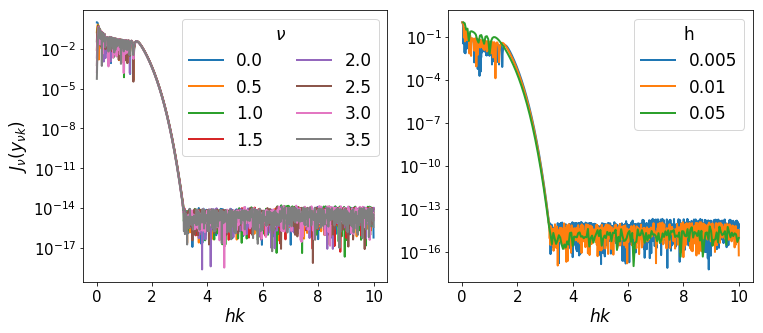

In [3]:
fig,ax = plt.subplots(1,2,figsize=(12,5), subplot_kw={"yscale":'log'})
for nu in np.arange(0,4,0.5):
    ht= HankelTransform(nu=nu,N=1000, h = 0.01)
    ax[0].plot(ht._h*np.arange(1,1001), np.abs(jv(ht._nu, ht.x)), label=str(nu))
    
for h in [0.005,0.01,0.05]:
    ht= HankelTransform(nu=0,N=10/h, h = h)
    ax[1].plot(ht._h*np.arange(1,10/h+1), np.abs(jv(ht._nu, ht.x)), label=str(h))
    
ax[0].legend(ncol=2, title=r"$\nu$")
ax[1].legend(title='h')
ax[0].set_ylabel(r"$J_\nu(y_{\nu k})$")
ax[0].set_xlabel(r"$hk$")
ax[1].set_xlabel(r"$hk$");

Interestingly, the fall-off is very similar across a range of both $\nu$ and $h$. We can compute where approximately the fall-off is completed:

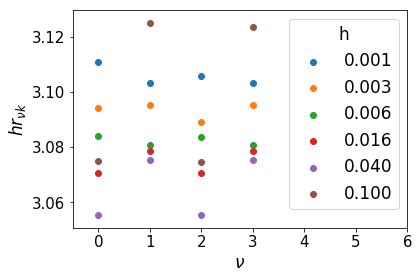

In [4]:
for i,nu in enumerate( np.arange(0,4)):
    for j,h in enumerate(np.logspace(-3,-1,6)):
        ht= HankelTransform(nu=nu,N=int(3.2/h), h = h)
        plt.scatter(nu,ht._h*ht._zeros[np.where(np.abs(jv(ht._nu, ht.x))<1e-13)[0][0]],color="C%s"%j,label="%.3f"%h if not i else None)
        
plt.xlabel(r"$\nu$")
plt.ylabel(r"$hr_{\nu k}$")
plt.xlim(-0.5,6)
plt.legend(title="h");

Clearly, we can cut the summation at $hr_{\nu k} = \pi$ without losing any precision. We do not want to sum further than this for two reasons: firstly, it is inefficient to do so, and secondly, we could be adding unnecessary numerical noise.

Now, let's assume that $N$ is reasonably large, so that the Bessel function is close to its asymptotic limit, in which
\begin{equation}
    r_{\nu k} = k - \frac{\pi \nu}{2} - \frac{\pi}{4} \approx k.
\end{equation}
Then we merely set $hr_{\nu k} = hN = 3.2$, i.e. $N = \pi/h$.

It may be a reasonable question to ask whether we could set $N$ significantly lower than this limit. 
The function $f(x)$ may converge faster than the Bessel function itself, in which case the limit could be reduced. In this regard it is useful to keep in mind that the sum extends to $r \sim \pi N$, if $N$ is reasonably large. If $f(x)$ falls to zero for $x \ll \pi^2/h$, then it is probably reasonable to use a lower value of $N$.

However, for simplicity, for the rest of our analysis, we consider $N$ to be set by this relation, and change $h$ to modify $N$.

### Choosing h

O5 give a rather involved proof of an upper limit on the residual error of their method as a function of $h$. 
Unfortunately, evaluating the upper limit is non-trivial, and we pursue a more tractable approach here, namely iteratively modifying $h$ until convergence is reached.

As an example, let's take a sharp Gaussian, $f(x) = e^{-(x-80)^2}$ with $\nu=0$:

Integral is:  -0.09651170657186205


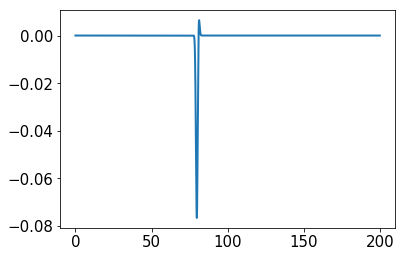

In [5]:
x = np.linspace(0,200.,1000000)
ff = lambda x : np.exp(-(x-80.)**2/1.)
plt.plot(x,ff(x) * jv(0,x))

res80 = simps(ff(x) * jv(0,x),x)
print("Integral is: ", res80)

In [6]:
print("h\tN\txmax\t#nodes in peak\t Rel. Err.")
print("---------------------------------------------")

for h in np.logspace(-4,0,10):
    N = int(np.pi/h)
    ht = HankelTransform(nu=0, h=h, N=N)
    G = ht.G(ff,h)
    ans,cum  = ht.integrate(f= ff,ret_cumsum=True,ret_err=False)
    print(f"{h:.2e}\t{N}\t{np.pi*N:.2e}\t{np.sum(np.logical_and(ht.x>78,ht.x<82))}\t{ans/res80 - 1:.2e}")


h	N	xmax	#nodes in peak	 Rel. Err.
---------------------------------------------
1.00e-04	31415	9.87e+04	10	-1.01e-14
2.78e-04	11290	3.55e+04	6	2.10e-08
7.74e-04	4057	1.27e+04	4	-5.55e-03
2.15e-03	1458	4.58e+03	3	2.76e-01
5.99e-03	524	1.65e+03	1	1.00e+00
1.67e-02	188	5.91e+02	1	-1.25e+00
4.64e-02	67	2.10e+02	1	1.38e+00
1.29e-01	24	7.54e+01	0	-1.00e+00
3.59e-01	8	2.51e+01	0	-1.00e+00
1.00e+00	3	9.42e+00	0	-1.00e+00


In the above example we see that only for very large values of $h$ was the criteria of negative derivative not met. However, the criteria of covering the interesting region with nodes was only met by the smallest 5 values of $h$, each of which yields a good value of the integral. 

Doing the same example, but moving the Gaussian closer to zero yields a different answer:

Integral is:  0.4168433779916697


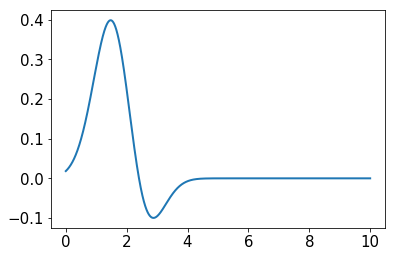

In [7]:
x = np.linspace(0,10,10000)
ff = lambda x : np.exp(-(x-2)**2)
plt.plot(x,ff(x) * jv(0,x))

res = simps(ff(x) * jv(0,x),x)
print("Integral is: ", res)

In [8]:
print("h\tN\txmax\t#nodes in peak\t Rel. Err.")
print("---------------------------------------------")

for h in np.logspace(-4,0,10):
    N = int(np.pi/h)
    ht = HankelTransform(nu=0, h=h, N=N)
    G = ht.G(ff,h)
    ans,cum  = ht.integrate(f= ff,ret_cumsum=True,ret_err=False)
    print(f"{h:.2e}\t{N}\t{np.pi*N:.2e}\t{np.sum(np.logical_and(ht.x>78,ht.x<82))}\t{ans/res - 1:.2e}")


h	N	xmax	#nodes in peak	 Rel. Err.
---------------------------------------------
1.00e-04	31415	9.87e+04	10	-2.47e-11
2.78e-04	11290	3.55e+04	6	-2.47e-11
7.74e-04	4057	1.27e+04	4	-2.47e-11
2.15e-03	1458	4.58e+03	3	-2.47e-11
5.99e-03	524	1.65e+03	1	2.45e-08
1.67e-02	188	5.91e+02	1	-1.09e-03
4.64e-02	67	2.10e+02	1	7.81e-02
1.29e-01	24	7.54e+01	0	5.37e-01
3.59e-01	8	2.51e+01	0	5.97e-01
1.00e+00	3	9.42e+00	0	6.09e-01


Here we are able to achieve good precision with just ~500 terms.

These ideas are built into the ``get_h`` function in ``hankel``. In particular, this function progressively iterates through a series of values for $h$, and stops when two consecutive results are within a certain tolerance of each other. On each iteration, it uses $N=\pi/h$. 

While this function is not entirely general -- there are cases in which the algorithm will return prematurely -- it should do well in cases where the integrand is reasonably smooth. In addition to the convergence of the result, it also checks that the derivative of $G$ is decreasing. Furthermore, it truncates $N$ if possible such that $f(x_k) = 0 \ \ \forall k > N$.

An example:

In [9]:
best_h, result, best_N = hankel.get_h(
    f =lambda x : np.exp(-(x-2)**2),
    nu=0
)
print(f"best_h = {best_h}, best_N={best_N}")
print("Relative Error: ", result/res - 1)

best_h = 0.0125, best_N=22
Relative Error:  -0.00011951202608917466


Here we can see that while a low value of $h$ was required, a corresponding high value of $N$ was not, as the function itself converges quickly.

We can also repeat our previous experiment where a sharp Gaussian sits at high $x$:

In [10]:
best_h, result, best_N = hankel.get_h(
    f =lambda x : np.exp(-(x-80.)**2),
    nu =0
)

print(f"best_h = {best_h}, best_N={best_N}")
print("Relative Error: ", result/res80 - 1)

best_h = 0.00078125, best_N=168
Relative Error:  0.002185348402481635


Here both a lower $h$ and higher $N$ are required, but again, $N$ does not need to be as large as $\pi/h$.

We can modify the required tolerance:

In [11]:
best_h, result, best_N = hankel.get_h(
    f =lambda x : np.exp(-(x-2)**2),
    nu=0,
    atol=1e-10,
    rtol=1e-15
)
print(f"best_h = {best_h}, best_N={best_N}")
print("Relative Error: ", result/res - 1)

best_h = 0.003125, best_N=44
Relative Error:  -2.470723625691562e-11


Remember that the tolerances submitted to the ``get_h`` function apply to the similarity between successive iterations. The relative error displayed here may be dominated by numerical error on the simpson's integration.

Finally we try a different kind of function, namely one that converges slowly:

In [12]:
best_h, result, best_N = hankel.get_h(
    f =lambda x : x**0.4,
    nu=0.5,
    atol=1e-5,
    rtol=1e-5
)
print(f"best_h = {best_h}, best_N={best_N} (max is {int(np.pi/best_h)})")
print("Relative Error: ", result/0.8421449 - 1)

best_h = 0.00625, best_N=502 (max is 502)
Relative Error:  2.317849153432583e-05


In this case, the required $N$ is the maximum required, as we need to integrate quite far in order to converge.

## Symmetric Fourier Transform

In the context of the symmetric Fourier Transform, much of the work is exactly the same -- the relationship between $N$ and $h$ necessarily remains. The only differences are that we now use the ``SymmetricFourierTransform`` class instead of the ``HankelTransform`` (and pass ``ndim`` rather than ``nu``), and that we are now interested in the *transform*, rather than the integral, so we have a particular set of scales, $K$, in mind.

For a given $K$, the minimum and maximum values of $x$ that we evaluate $f(x)$ for are $x_{\rm min} \approx \pi^2 h r^2_{\nu 1}/2K$ and $x_{\rm max} \approx \pi N/K$. We suggest find a value $h$ that works for both the minimum and maximum $K$ desired. All scales in between should work in this case.

We have already written this functionality into the ``get_h`` function. However, here ``nu`` is interpreted directly as ``n``, and we need to pass a value for $K$.

In [13]:
hankel.get_h(
    f = lambda x : np.exp(-x**2), nu=2, 
    K= np.array([0.01, 100]), 
    cls=SymmetricFourierTransform
)

(0.05, array([8.25274593e-88, 1.38996118e-09]), 62)